In [ ]:
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
)
from langchain.docstore.document import Document as LangchainDocument
from typing import Optional, List

import questllama.core.utils.file_utils as U
import questllama.core.utils.log_utils as L
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

# Utility functions

In [ ]:
def read_knowledge_database():
    action_files = U.read_skill_library("skill_library", full_path=True)
    return [
        LangchainDocument(page_content=doc[1], metadata={"source": doc[0]})
        for doc in action_files
    ]


# Read the skill library

In [ ]:
RAW_KNOWLEDGE_BASE = read_knowledge_database()
i = 0
print(f"Read {len(RAW_KNOWLEDGE_BASE)} files")
print(f"============= Example {i} ========================")
print(f"source: {RAW_KNOWLEDGE_BASE[0].metadata['source']}")
print(f"content:{RAW_KNOWLEDGE_BASE[0].page_content}")

# Encode the knowledge database.


In [32]:
JAVASCRIPT_SEPARATORS = [
    "\nfunction ",
    "\nconst ",
    "\nlet ",
    "\nvar ",
    "\nclass ",
    "\nif ",
    "\nfor ",
    "\nwhile ",
    "\nswitch ",
    "\ncase ",
    "\ndefault ",
    "\n\n",
    "\n",
    " ",
    "",
]
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str],
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # FIXME: Is it necessary to pass the separators here? Try without them.
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=JAVASCRIPT_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique, tokenizer


Using encoder defined at flax-sentence-embeddings/st-codesearch-distilroberta-base.
Model's maximum sequence length: 128
Chunk size: 128.
127


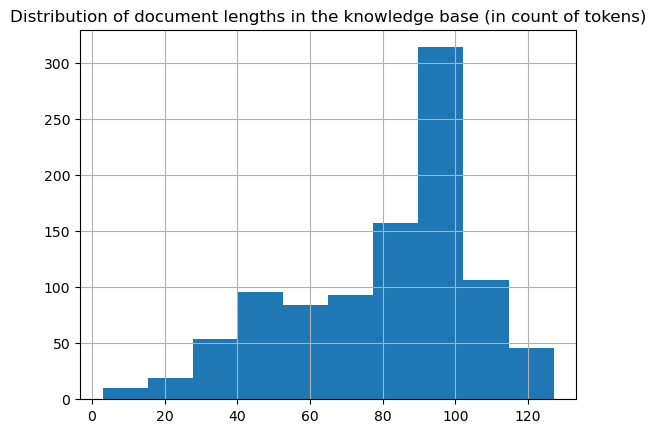

In [38]:
EMBEDDING_MODEL_NAME="flax-sentence-embeddings/st-codesearch-distilroberta-base"
CHUNK_SIZE = 128

print(f"Using encoder defined at {EMBEDDING_MODEL_NAME}.")
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")
print(f"Chunk size: {CHUNK_SIZE}.")

docs_processed, tokenizer = split_documents(CHUNK_SIZE, RAW_KNOWLEDGE_BASE, EMBEDDING_MODEL_NAME)

lengths = [
    len(tokenizer.encode(doc.page_content)) for doc in docs_processed
]

fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()

# Building the vector database
## Load the embedding model

In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

## Create the knowledge vector database

In [39]:
# embed a user query in the same space
user_query = "// craft a furnace."
query_vector = embedding_model.embed_query(user_query)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [40]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='// craft a furnace.'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



==================================Top document==================================
// Craft a furnace using the cobblestones
  await craftItem(bot, "furnace", 1);
  bot.chat("Furnace crafted.");
}
==================================Metadata==================================
{'source': '/home/atomwalk12/repos/QuestLlama/questllama/skill_library/trial5/skill/code/craftFurnace.js', 'start_index': 741}


# Reader model

In [43]:
from transformers import pipeline
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "deepseek-ai/deepseek-coder-33b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/48.5k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/9.73G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/9.92G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/9.82G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/9.92G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/7.38G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [61]:
text = READER_LLM("Kill 1 zombie.")

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


# Prompt template

In [63]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<｜begin▁of▁sentence｜>Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.### Instruction:
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
### Response:



In [64]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to kill 1 zombie?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


To kill 1 zombie, you would first need to locate the zombie. This can usually be done by looking for any hostile mobs around you. Once you've located the zombie, you can attack it with your weapon or tool until it dies. Here's how this could look in code:

```javascript
// Locate the zombie
const zombies = bot.entities.filter((e) => e.type === 'zombie');
if (zombies.length === 0) {
  bot.chat('No zombies found.');
  return;
}

// Attack the zombie
for (let i = 0; i < zombies.length; i++) {
  const zombie = zombies[i];
  await bot.lookAt(zombie.position);
  await bot.attack(zombie);
  
  // Wait for the zombie to die
  while (zombie.isAlive) {
    await new Promise((resolve) => setTimeout(resolve, 100));
  }
  
  break;
}

bot.chat('Zombie killed.');
```

Please note that this is just a basic example and may not work perfectly in all situations. The actual implementation will depend on the specific game mechanics and requirements.



# Reranking

In [1]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

ImportError: cannot import name 'Index' from 'voyager' (/home/atomwalk12/repos/QuestLlama/voyager/__init__.py)